# PINN pour un circuit RC-AC avec une perte physique 
### Decomment 2nd block of code for consistent initialising seed
### Network trained with dataset used ***without DataLoader***

In [59]:
import torch
print(torch.__version__)


2.2.2+cpu


<u>Import nécessaire :</u>

In [60]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv 
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import random


In [61]:
# Initialise random seed for model weights and activations

"""def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # If using torch.backends (optional for CPU, more relevant for CUDA)
    if torch.backends.mps.is_available():
        torch.use_deterministic_algorithms(True)

set_seed(42)"""

'def set_seed(seed=42):\n    torch.manual_seed(seed)\n    np.random.seed(seed)\n    random.seed(seed)\n\n    # If using torch.backends (optional for CPU, more relevant for CUDA)\n    if torch.backends.mps.is_available():\n        torch.use_deterministic_algorithms(True)\n\nset_seed(42)'

In [62]:
# A  COMPLETER AVEC LE NOM DU FICHIER CSV
df = pd.read_csv("rc_ac_results_800.csv")
#print(df)
print(df.shape)

(800, 6)


In [63]:

# Data normalisation
X = df[ [ "R" , "C" , "Vin" , "Frequency" ] ].values
Y = df[ [ "Magnitude", "Phase" ] ].values

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_tensor = torch.tensor( scaler_x.fit_transform(X) , dtype = torch.float32 )
Y_tensor = torch.tensor( scaler_y.fit_transform(Y) , dtype = torch.float32 )

#print(X_tensor[:,0])
#print(Y_tensor)

dataset = TensorDataset( X_tensor , Y_tensor )

#loader = DataLoader(dataset, batch_size=32, shuffle=True)

R = X_tensor[:,0]
C = X_tensor[:,1]
Frequency = X_tensor[:,3]
print(R)
print(C)

print((R*C).shape)

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -

In [64]:
class RegressionModel(nn.Module):
    def __init__( self , in_features , out_features = 2 ):
        super().__init__()

        """"
        nn.Linear( a , b ) crée une couche fully connected

            a : neurones en input
            b : neurones en output
        """
        self.fc1 = nn.Linear( in_features , 8 )
        self.fc2 = nn.Linear( 8 , 16 )
        self.fc3 = nn.Linear( 16 , 64 )
        self.fc4 = nn.Linear( 64 , 32 )
        self.fc5 = nn.Linear( 32 , 8 )
        self.fc6 = nn.Linear( 8 , 2 )
        


    def forward( self , x ):
        x = F.relu( self.fc1( x ) )
        x = F.relu( self.fc2( x ) )
        x = F.relu( self.fc3( x ) )
        x = F.relu( self.fc4( x ) )
        x = F.relu( self.fc5( x ) )
        x = self.fc6( x )  # No activation on output for regression
        return x

In [65]:
in_features = 4
out_features = 2


model = RegressionModel( in_features , out_features=2 )

criterion = nn.MSELoss()
optimizer = optim.Adam( model.parameters() , lr = 0.001 )


## The differential equation that controls our physics loss 

## ⚙️ Differential Equation of an RC Circuit (Time Domain)

The first-order differential equation for the voltage across a capacitor in an RC circuit is:

$$
RC \cdot \frac{du(t)}{dt} + u(t) = V_0 \cdot \sin(\omega t)
$$

Where:
- \( u(t) \) is the output voltage (e.g. across the capacitor),
- \( R \) is the resistance (Ω),
- \( C \) is the capacitance (F),
- \( U \) is the constant input voltage.

This equation describes the dynamic response of the voltage in the circuit over time.


In [66]:
# Function to compute the PDE residual: 

def pde_residual( model , x ):
    # Make sure x is set to require gradients for derivative calculations.
    x = x.clone().detach().requires_grad_( True )
    u = model( x )
    
    #t = x[ :, 0]
    # Compute the first derivative, du/dt.
    #u_x = ( torch.autograd.grad( u , t , grad_outputs = torch.ones_like(u) , create_graph = True )[ 0 ] )[ :,0 ]
    
    """print( u_x.shape )
    print( x.shape )
    print( u[:,0].shape )"""

    R = x[:, 0]
    C = x[:, 1]
    Vin = x[:, 2]
    Frequency = x[:, 3]
    w = 2 * torch.pi * Frequency

    mag = u[ :, 0 ]
    phase = u[ :, 1 ]

    """print(R.shape)
    print(C.shape)
    print(U.shape)"""

    # Formules physiques
    mag_2 = Vin / torch.sqrt( 1 + ( w * R * C ) ** 2 )
    phase_2 = -torch.atan( w * R * C )

    
    residual_mag = (mag - mag_2 )
    residual_phase = (phase - phase_2 )
    residual = ( residual_mag ** 2 ) + ( residual_phase ** 2 )
    return residual


#pde_test = pde_residual(model, X_tensor)
#print(pde_test)
#print(pde_test.shape)



Epoch [1], Loss: 2.963945389
Epoch [2], Loss: 2.957866669
Epoch [3], Loss: 2.951762199
Epoch [4], Loss: 2.945669651
Epoch [5], Loss: 2.939568758
Epoch [6], Loss: 2.933512211
Epoch [7], Loss: 2.927552700
Epoch [8], Loss: 2.921662331
Epoch [9], Loss: 2.915814400
Epoch [10], Loss: 2.910134315
Epoch [11], Loss: 2.905441999
Epoch [12], Loss: 2.901850224
Epoch [13], Loss: 2.898477793
Epoch [14], Loss: 2.895364761
Epoch [15], Loss: 2.892160892
Epoch [16], Loss: 2.888935804
Epoch [17], Loss: 2.885702610
Epoch [18], Loss: 2.882461309
Epoch [19], Loss: 2.879214287
Epoch [20], Loss: 2.875958443
Epoch [21], Loss: 2.872671604
Epoch [22], Loss: 2.869358063
Epoch [23], Loss: 2.866014481
Epoch [24], Loss: 2.862643719
Epoch [25], Loss: 2.859247684
Epoch [26], Loss: 2.855827808
Epoch [27], Loss: 2.852390289
Epoch [28], Loss: 2.848942280
Epoch [29], Loss: 2.845482826
Epoch [30], Loss: 2.842015266
Epoch [31], Loss: 2.838540077
Epoch [32], Loss: 2.835064650
Epoch [33], Loss: 2.831596375
Epoch [34], Loss: 2

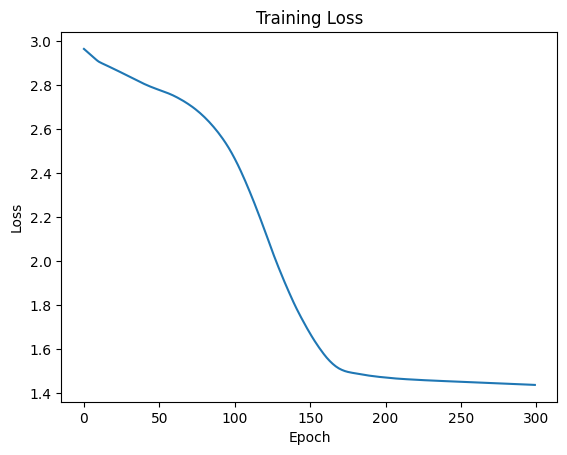

In [67]:
nb_epochs = 300
losses = []
# Before training
#set_seed(42)
model.train()
for i in range(nb_epochs):
    """for X_batch, Y_batch in loader:
        
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()"""
    

    # Physics loss
    res = pde_residual( model , X_tensor )
    loss_physics = torch.mean( res )

    # MSE loss
    outputs = model( X_tensor )
    loss_mse = criterion( outputs , Y_tensor ) 

    # final loss
    loss = loss_mse + loss_physics

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append( loss.item() )


    print( f'Epoch [{i+ 1}], Loss: {loss.item():.9f}' )

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

   

In [68]:
model.eval()

# No gradient calculation during evaluation
with torch.no_grad():
    # Forward pass
    predictions = model( X_tensor )  # Assuming X_tensor is your input data

    # Calculate the loss (optional)
    loss = criterion( predictions , Y_tensor )
    print( f"Evaluation Loss: {loss.item():.3f}" )

    predictions_original = scaler_y.inverse_transform( predictions.numpy() )

    # Print the inverse transformed predictions
    print( "Inverse Predictions: \n", predictions_original )

Evaluation Loss: 1.139
Inverse Predictions: 
 [[ 7.4810058e-02 -6.6991257e+01]
 [ 7.1587943e-02 -6.7451920e+01]
 [ 6.8365782e-02 -6.7912582e+01]
 ...
 [ 3.4292214e-02 -9.7831337e+01]
 [ 3.3546947e-02 -9.7803246e+01]
 [ 3.2797873e-02 -9.7774887e+01]]


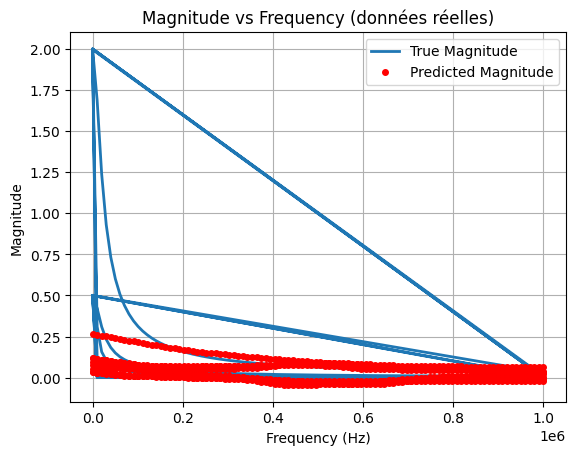

In [69]:
"""plt.title( "Training and predicting (with normalised data)" )

plt.plot( X_tensor[:,2] , Y_tensor[:,0] , label = "True V_out" )
plt.xlabel( "U input" )
plt.ylabel( "U output" , rotation = 0 , labelpad=30 )
plt.plot( X_tensor[:,2] , predictions[:,0] , label = "Predicted V_out" , color='red' , linestyle='None' , marker='o' , markersize=5 )
plt.legend()


plt.show()"""
# Dénormalisation des prédictions et des vraies valeurs
predictions_original = scaler_y.inverse_transform(predictions.numpy())
Y_true_original = scaler_y.inverse_transform(Y_tensor.numpy())

# Dénormalisation de la fréquence
frequencies = scaler_x.inverse_transform(X_tensor.numpy())[:, 3]

# Tracé magnitude réelle vs prédite
plt.figure()
plt.plot(frequencies, Y_true_original[:, 0], label="True Magnitude", linewidth=2)
plt.plot(frequencies, predictions_original[:, 0], 'o', label="Predicted Magnitude", markersize=4, color='red')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Magnitude vs Frequency (données réelles)")
plt.legend()
plt.grid(True)
plt.show()


In [70]:
# Print model's state_dict
print( "Model's state_dict:" )
for param_tensor in model.state_dict():
    print( param_tensor, "\t", model.state_dict()[param_tensor].size() )

# Print optimizer's state_dict
"""print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])"""



Model's state_dict:
fc1.weight 	 torch.Size([8, 4])
fc1.bias 	 torch.Size([8])
fc2.weight 	 torch.Size([16, 8])
fc2.bias 	 torch.Size([16])
fc3.weight 	 torch.Size([64, 16])
fc3.bias 	 torch.Size([64])
fc4.weight 	 torch.Size([32, 64])
fc4.bias 	 torch.Size([32])
fc5.weight 	 torch.Size([8, 32])
fc5.bias 	 torch.Size([8])
fc6.weight 	 torch.Size([2, 8])
fc6.bias 	 torch.Size([2])


'print("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])'

In [71]:
# Defining model name and save the model

name = "My_model"    # À changer selon l'utilisateur
torch.save( model.state_dict() , name )

# Load the saved model and evaluate

my_model = RegressionModel( in_features , out_features )
my_model.load_state_dict( torch.load( name , weights_only = True ) )
my_model.eval()


with torch.no_grad():
    # Forward pass
    predictions = my_model( X_tensor )  

    # Calculate the loss (optional)
    loss = criterion( predictions , Y_tensor )
    print( f"Evaluation Loss: {loss.item():.3f}" )

Evaluation Loss: 1.139
